In [1]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn torch torchvision torchaudio


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [6]:
# Load GMSL data
gmsl_df = pd.read_csv('sealevel.csv')

# Display first few rows
gmsl_df.head()


,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
0,1993,327401.31,-38.59,89.86,-38.76,-38.59,89.86,-38.75,-38.57
1,1993,324498.41,-41.97,90.86,-39.78,-41.97,90.86,-39.77,-39.11
2,1993,333018.19,-41.93,87.27,-39.62,-41.91,87.27,-39.61,-38.58
3,1993,297483.19,-42.67,90.75,-39.67,-42.65,90.74,-39.64,-38.34
4,1993,321635.81,-37.86,90.26,-38.75,-37.83,90.25,-38.72,-37.21


In [8]:
# Convert Year to integer (in case it's not)
gmsl_df['Year'] = gmsl_df['Year'].astype(int)

# Aggregate by Year
gmsl_yearly = gmsl_df.groupby('Year').mean().reset_index()

# Display the aggregated data
gmsl_yearly.head()


,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
0,1993,319044.908649,-34.605405,87.603784,-34.629459,-34.483784,87.607027,-34.507568,-34.508378
1,1994,323836.882162,-30.951081,87.412432,-30.898919,-30.584324,87.418919,-30.532432,-30.531892
2,1995,317986.154865,-28.645946,85.336757,-27.971351,-28.019459,85.337838,-27.359189,-27.358108
3,1996,323979.240278,-26.596389,84.194444,-26.140833,-25.744167,84.188611,-25.288611,-25.287222
4,1997,321345.634054,-22.682432,97.989189,-22.345946,-21.591081,98.000000,-21.254865,-21.255676


In [10]:
# Load Temperature data
temp_df = pd.read_csv('GLB.Ts+dSST.csv')

# Display first few rows
temp_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.20,-0.25,-0.09,-0.16,-0.09,-0.22,-0.20,-0.09,-.15,-.22,-.22,-.18,-.17,***,***,-0.11,-0.17,-.20
1,1881,-0.19,-0.15,0.02,0.04,0.07,-0.19,0.01,-0.04,-.16,-.22,-.18,-.07,-.09,-.10,-.18,0.04,-0.07,-.19
2,1882,0.16,0.14,0.05,-0.15,-0.13,-0.22,-0.16,-0.07,-.14,-.23,-.17,-.36,-.11,-.08,.08,-0.08,-0.15,-.18
3,1883,-0.29,-0.36,-0.12,-0.18,-0.18,-0.07,-0.07,-0.14,-.22,-.11,-.24,-.11,-.17,-.20,-.34,-0.16,-0.09,-.19
4,1884,-0.12,-0.08,-0.36,-0.40,-0.33,-0.35,-0.30,-0.28,-.27,-.25,-.33,-.30,-.28,-.27,-.10,-0.36,-0.31,-.28


In [11]:
# Replace '***' with NaN
temp_df = temp_df.replace('***', np.nan)

# Convert columns to numeric
cols = temp_df.columns.drop('Year')
temp_df[cols] = temp_df[cols].apply(pd.to_numeric, errors='coerce')

# Display cleaned data
temp_df.head()


,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.20,-0.25,-0.09,-0.16,-0.09,-0.22,-0.20,-0.09,-0.15,-0.22,-0.22,-0.18,-0.17,NaN,NaN,-0.11,-0.17,-0.20
1,1881,-0.19,-0.15,0.02,0.04,0.07,-0.19,0.01,-0.04,-0.16,-0.22,-0.18,-0.07,-0.09,-0.10,-0.18,0.04,-0.07,-0.19
2,1882,0.16,0.14,0.05,-0.15,-0.13,-0.22,-0.16,-0.07,-0.14,-0.23,-0.17,-0.36,-0.11,-0.08,0.08,-0.08,-0.15,-0.18
3,1883,-0.29,-0.36,-0.12,-0.18,-0.18,-0.07,-0.07,-0.14,-0.22,-0.11,-0.24,-0.11,-0.17,-0.20,-0.34,-0.16,-0.09,-0.19
4,1884,-0.12,-0.08,-0.36,-0.40,-0.33,-0.35,-0.30,-0.28,-0.27,-0.25,-0.33,-0.30,-0.28,-0.27,-0.10,-0.36,-0.31,-0.28


In [12]:
# Keep only Year and 'J-D' (Annual Mean)
temp_yearly = temp_df[['Year', 'J-D']].dropna()

# Rename 'J-D' to 'TempAnomaly'
temp_yearly.rename(columns={'J-D': 'TempAnomaly'}, inplace=True)

# Display the data
print(temp_yearly.head())


   Year  TempAnomaly
0  1880        -0.17
1  1881        -0.09
2  1882        -0.11
3  1883        -0.17
4  1884        -0.28


In [13]:
# Merge datasets on Year
merged_df = pd.merge(gmsl_yearly, temp_yearly, on='Year')

# Display the merged data
print(merged_df.head())


   Year  TotalWeightedObservations  GMSL_noGIA  StdDevGMSL_noGIA  \
0  1993              319044.908649  -34.605405         87.603784   
1  1994              323836.882162  -30.951081         87.412432   
2  1995              317986.154865  -28.645946         85.336757   
3  1996              323979.240278  -26.596389         84.194444   
4  1997              321345.634054  -22.682432         97.989189   

   SmoothedGSML_noGIA   GMSL_GIA  StdDevGMSL_GIA  SmoothedGSML_GIA  \
0          -34.629459 -34.483784       87.607027        -34.507568   
1          -30.898919 -30.584324       87.418919        -30.532432   
2          -27.971351 -28.019459       85.337838        -27.359189   
3          -26.140833 -25.744167       84.188611        -25.288611   
4          -22.345946 -21.591081       98.000000        -21.254865   

   SmoothedGSML_GIA_sigremoved  TempAnomaly  
0                   -34.508378         0.23  
1                   -30.531892         0.31  
2                   -27.358108  

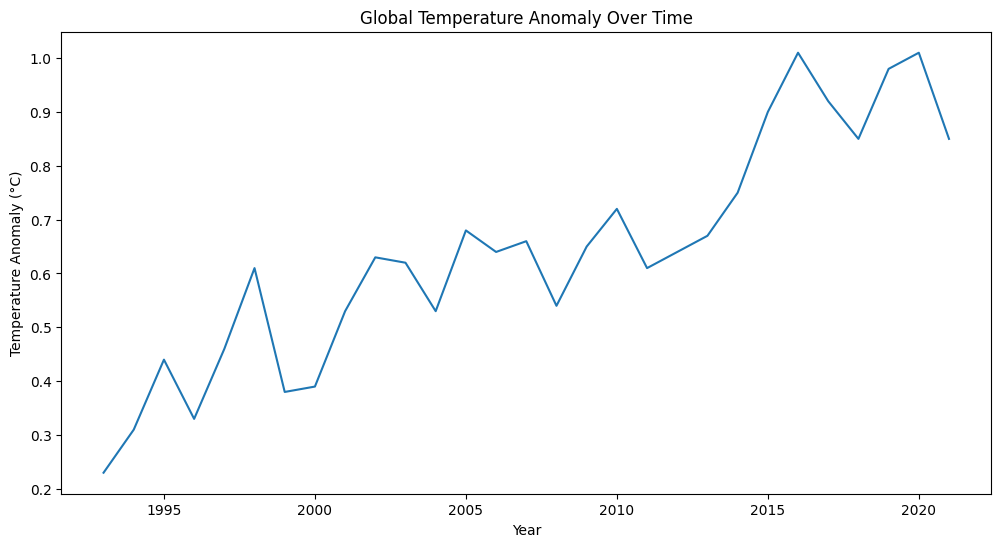

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Year', y='TempAnomaly')
plt.title('Global Temperature Anomaly Over Time')
plt.ylabel('Temperature Anomaly (°C)')
plt.show()


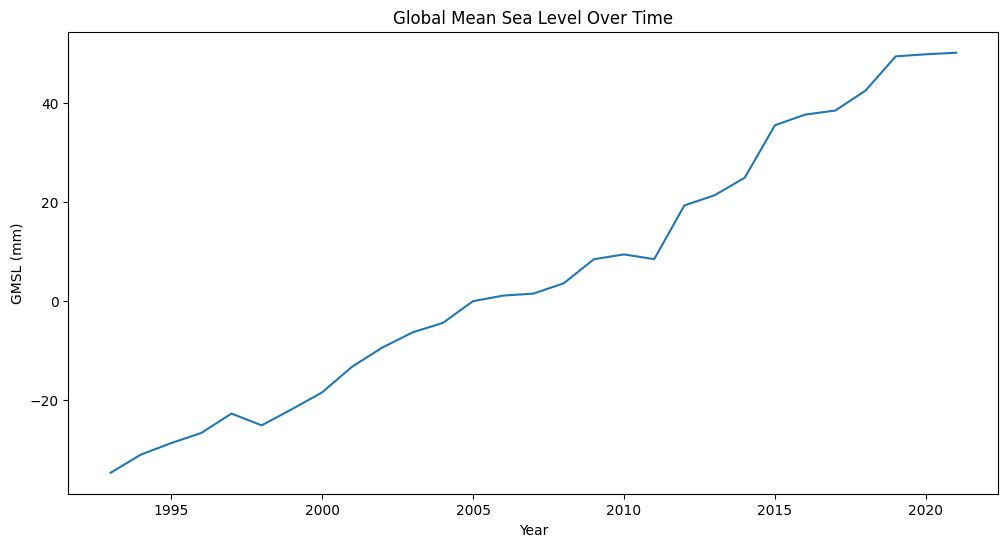

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Year', y='GMSL_noGIA')
plt.title('Global Mean Sea Level Over Time')
plt.ylabel('GMSL (mm)')
plt.show()


In [16]:
# Compute correlation
corr = merged_df['TempAnomaly'].corr(merged_df['GMSL_noGIA'])
print(f'Correlation between Temperature Anomaly and GMSL: {corr:.4f}')


Correlation between Temperature Anomaly and GMSL: 0.9292


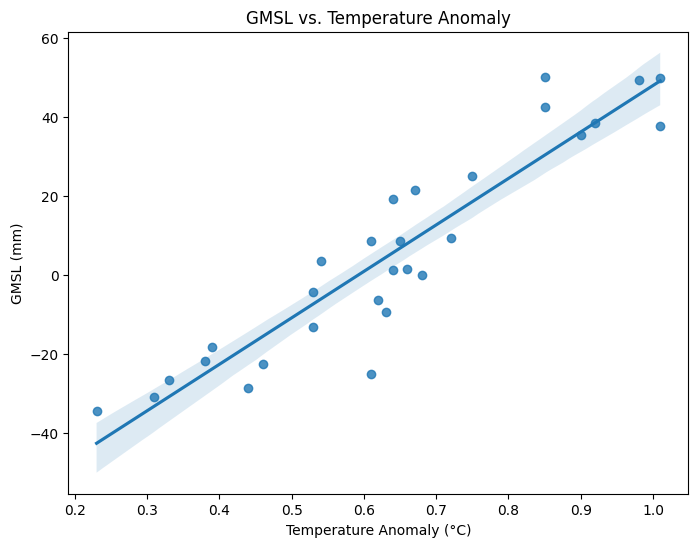

In [17]:
plt.figure(figsize=(8, 6))
sns.regplot(x='TempAnomaly', y='GMSL_noGIA', data=merged_df)
plt.title('GMSL vs. Temperature Anomaly')
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('GMSL (mm)')
plt.show()


In [18]:
# Features and target variable
X = merged_df[['TempAnomaly']].values
y = merged_df['GMSL_noGIA'].values


In [19]:
from sklearn.model_selection import train_test_split

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Initialize model
lin_reg = LinearRegression()

# Train model
lin_reg.fit(X_train, y_train)

# Coefficient and Intercept
print(f'Coefficient: {lin_reg.coef_[0]:.4f}')
print(f'Intercept: {lin_reg.intercept_:.4f}')


Coefficient: 117.8232
Intercept: -68.6307


In [21]:
# Predict on test set
y_pred = lin_reg.predict(X_test)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')


Mean Squared Error: 68.4846
R^2 Score: 0.8724


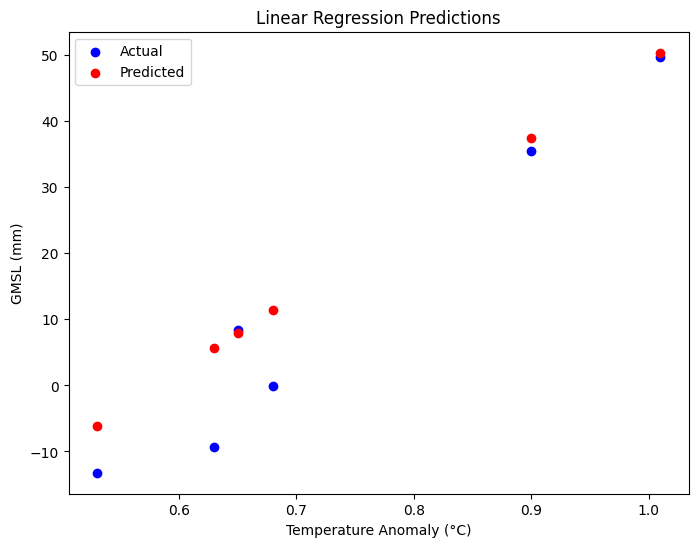

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.title('Linear Regression Predictions')
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('GMSL (mm)')
plt.legend()
plt.show()


In [23]:
# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)


In [24]:
class SeaLevelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset
dataset = SeaLevelDataset(X_tensor, y_tensor)


In [25]:
from torch.utils.data import random_split

# Calculate lengths
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [26]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)


In [27]:
class SeaLevelModel(nn.Module):
    def __init__(self):
        super(SeaLevelModel, self).__init__()
        self.linear1 = nn.Linear(1, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 8)
        self.linear3 = nn.Linear(8, 1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.relu(self.linear2(out))
        out = self.linear3(out)
        return out

# Initialize model
model = SeaLevelModel()


In [28]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [29]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        
        # Compute loss
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 432.8670
Epoch [20/100], Loss: 442.7301
Epoch [30/100], Loss: 268.5637
Epoch [40/100], Loss: 38.7463
Epoch [50/100], Loss: 68.6130
Epoch [60/100], Loss: 324.7635
Epoch [70/100], Loss: 21.6068
Epoch [80/100], Loss: 5.1256
Epoch [90/100], Loss: 64.9996
Epoch [100/100], Loss: 20.9246


In [30]:
model.eval()
with torch.no_grad():
    y_pred_list = []
    y_actual_list = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_pred_list.extend(outputs.numpy())
        y_actual_list.extend(y_batch.numpy())

# Convert lists to arrays
y_pred_array = np.array(y_pred_list)
y_actual_array = np.array(y_actual_list)

# Compute metrics
mse_nn = mean_squared_error(y_actual_array, y_pred_array)
r2_nn = r2_score(y_actual_array, y_pred_array)

print(f'Neural Network Mean Squared Error: {mse_nn:.4f}')
print(f'Neural Network R^2 Score: {r2_nn:.4f}')


Neural Network Mean Squared Error: 138.3906
Neural Network R^2 Score: 0.6502


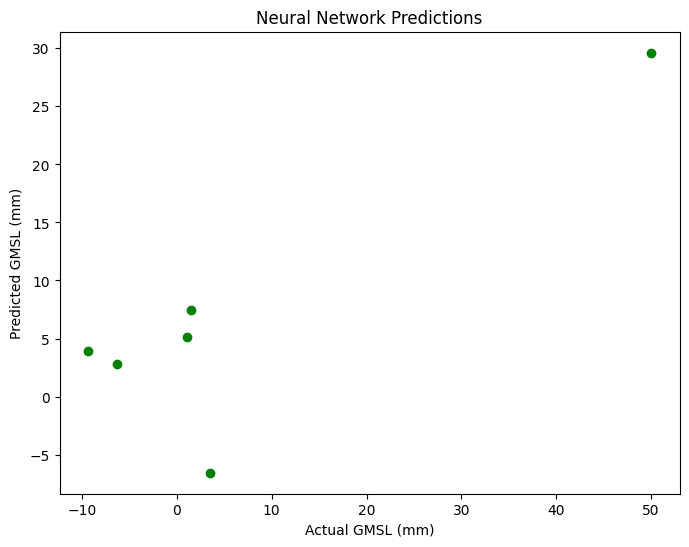

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_actual_array, y_pred_array, color='green')
plt.title('Neural Network Predictions')
plt.xlabel('Actual GMSL (mm)')
plt.ylabel('Predicted GMSL (mm)')
plt.show()


# Feature Engineering
## Time-Lagged Features
Sea level rise may not respond immediately to temperature changes. We'll create lagged temperature anomaly features.

In [32]:
# Create lagged temperature anomalies (up to 5 years)
for lag in range(1, 6):
    merged_df[f'TempAnomaly_Lag{lag}'] = merged_df['TempAnomaly'].shift(lag)

# Drop rows with NaN values resulting from lagging
merged_df_lagged = merged_df.dropna().reset_index(drop=True)


In [33]:
# Define features and target variable
X = merged_df_lagged[['TempAnomaly', 'TempAnomaly_Lag1', 'TempAnomaly_Lag2',
                      'TempAnomaly_Lag3', 'TempAnomaly_Lag4', 'TempAnomaly_Lag5']]
y = merged_df_lagged['GMSL_noGIA']


In [34]:
# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [36]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [37]:
# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)


In [38]:
# Initialize model
lin_reg = LinearRegression()

# Train model
lin_reg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_lin = lin_reg.predict(X_test_scaled)

# Evaluate model
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print(f'Linear Regression MSE: {mse_lin:.4f}')
print(f'Linear Regression R^2 Score: {r2_lin:.4f}')


Linear Regression MSE: 102.3172
Linear Regression R^2 Score: -3.5709


In [39]:
# Transform features to polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Initialize and train model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Predict on test set
y_pred_poly = poly_reg.predict(X_test_poly)

# Evaluate model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f'Polynomial Regression MSE: {mse_poly:.4f}')
print(f'Polynomial Regression R^2 Score: {r2_poly:.4f}')


Polynomial Regression MSE: 18574.4197
Polynomial Regression R^2 Score: -828.7941


In [40]:
# Initialize model
dt_reg = DecisionTreeRegressor(random_state=42)

# Train model
dt_reg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_dt = dt_reg.predict(X_test_scaled)

# Evaluate model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f'Decision Tree Regression MSE: {mse_dt:.4f}')
print(f'Decision Tree Regression R^2 Score: {r2_dt:.4f}')


Decision Tree Regression MSE: 93.0642
Decision Tree Regression R^2 Score: -3.1576


In [41]:
# Initialize model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Train model
rf_reg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rf = rf_reg.predict(X_test_scaled)

# Evaluate model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Regression MSE: {mse_rf:.4f}')
print(f'Random Forest Regression R^2 Score: {r2_rf:.4f}')


Random Forest Regression MSE: 217.2393
Random Forest Regression R^2 Score: -8.7050


In [42]:
# Initialize model
svr_reg = SVR(kernel='rbf')

# Train model
svr_reg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_svr = svr_reg.predict(X_test_scaled)

# Evaluate model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f'Support Vector Regression MSE: {mse_svr:.4f}')
print(f'Support Vector Regression R^2 Score: {r2_svr:.4f}')


Support Vector Regression MSE: 2171.5471
Support Vector Regression R^2 Score: -96.0117


In [43]:
# Initialize model
gb_reg = GradientBoostingRegressor(random_state=42)

# Train model
gb_reg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_gb = gb_reg.predict(X_test_scaled)

# Evaluate model
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting Regression MSE: {mse_gb:.4f}')
print(f'Gradient Boosting Regression R^2 Score: {r2_gb:.4f}')


Gradient Boosting Regression MSE: 113.6962
Gradient Boosting Regression R^2 Score: -4.0793


In [44]:
# Create a DataFrame to compare model performances
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression', 'Decision Tree', 
              'Random Forest', 'Support Vector Regression', 'Gradient Boosting'],
    'MSE': [mse_lin, mse_poly, mse_dt, mse_rf, mse_svr, mse_gb],
    'R^2 Score': [r2_lin, r2_poly, r2_dt, r2_rf, r2_svr, r2_gb]
})

print(model_comparison)


                       Model           MSE   R^2 Score
0          Linear Regression    102.317206   -3.570921
1      Polynomial Regression  18574.419667 -828.794057
2              Decision Tree     93.064193   -3.157552
3              Random Forest    217.239263   -8.704952
4  Support Vector Regression   2171.547105  -96.011746
5          Gradient Boosting    113.696206   -4.079267


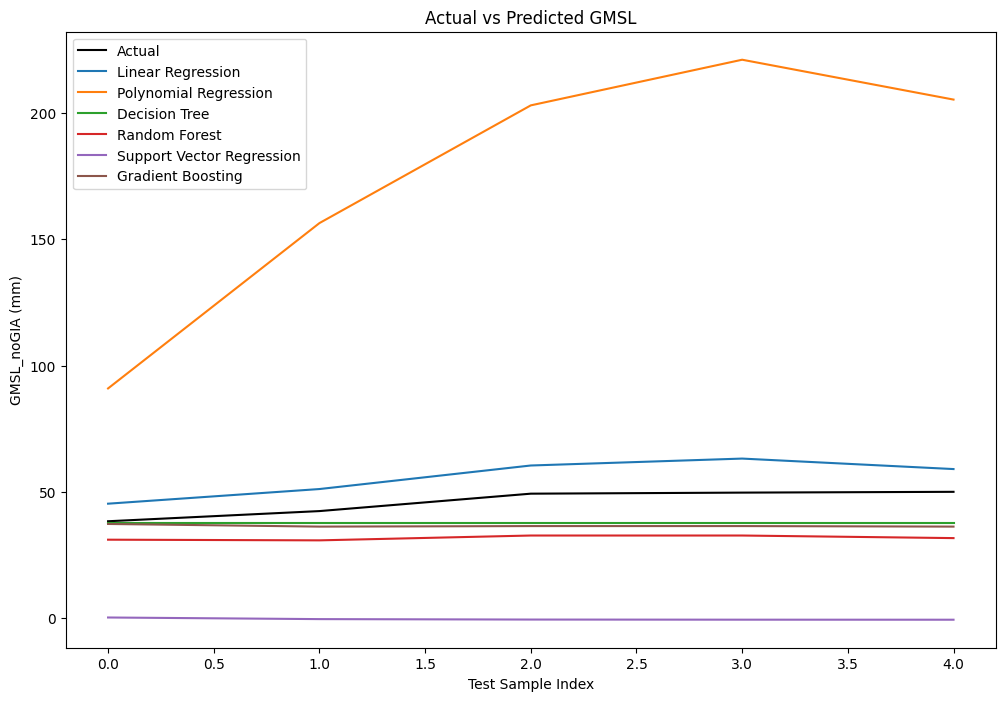

In [45]:
models = {
    'Linear Regression': y_pred_lin,
    'Polynomial Regression': y_pred_poly,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'Support Vector Regression': y_pred_svr,
    'Gradient Boosting': y_pred_gb
}

plt.figure(figsize=(12, 8))
plt.plot(y_test.values, label='Actual', color='black')

for name, y_pred in models.items():
    plt.plot(y_pred, label=name)

plt.title('Actual vs Predicted GMSL')
plt.xlabel('Test Sample Index')
plt.ylabel('GMSL_noGIA (mm)')
plt.legend()
plt.show()


In [46]:
from statsmodels.tsa.stattools import grangercausalitytests

# Prepare data for Granger causality test
# The data needs to be in the form [y, x]
granger_data = merged_df[['GMSL_noGIA', 'TempAnomaly']].dropna()

# Perform Granger causality test
maxlag = 5
granger_results = grangercausalitytests(granger_data, maxlag=maxlag, verbose=False)

# Extract p-values
p_values = [round(granger_results[i+1][0]['ssr_ftest'][1], 4) for i in range(maxlag)]
print('Granger Causality Test p-values:')
for lag, p_value in enumerate(p_values):
    print(f'Lag {lag+1}: p-value = {p_value}')


Granger Causality Test p-values:
Lag 1: p-value = 0.0325
Lag 2: p-value = 0.0419
Lag 3: p-value = 0.1616
Lag 4: p-value = 0.1705
Lag 5: p-value = 0.173


/Users/ruwadnaswan/Desktop/fastApi/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


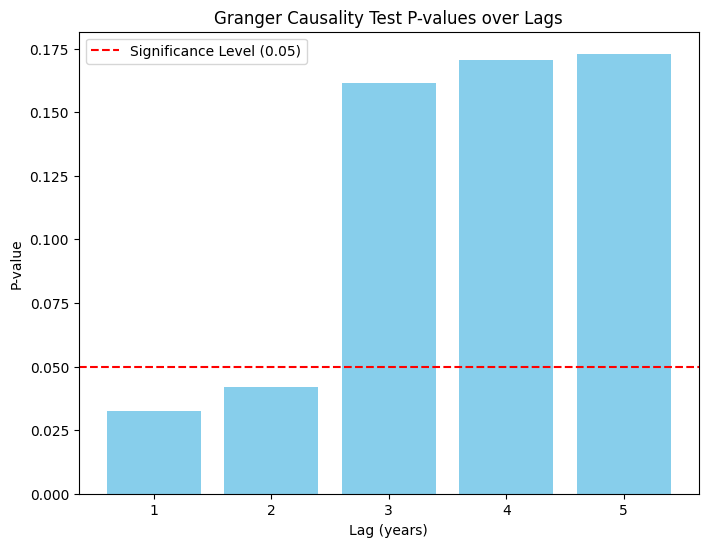

In [47]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Granger Causality Test p-values
lags = [1, 2, 3, 4, 5]
p_values = [0.0325, 0.0419, 0.1616, 0.1705, 0.173]

# Plot the p-values
plt.figure(figsize=(8, 6))
plt.bar(lags, p_values, color='skyblue')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.title('Granger Causality Test P-values over Lags')
plt.xlabel('Lag (years)')
plt.ylabel('P-value')
plt.xticks(lags)
plt.legend()
plt.show()


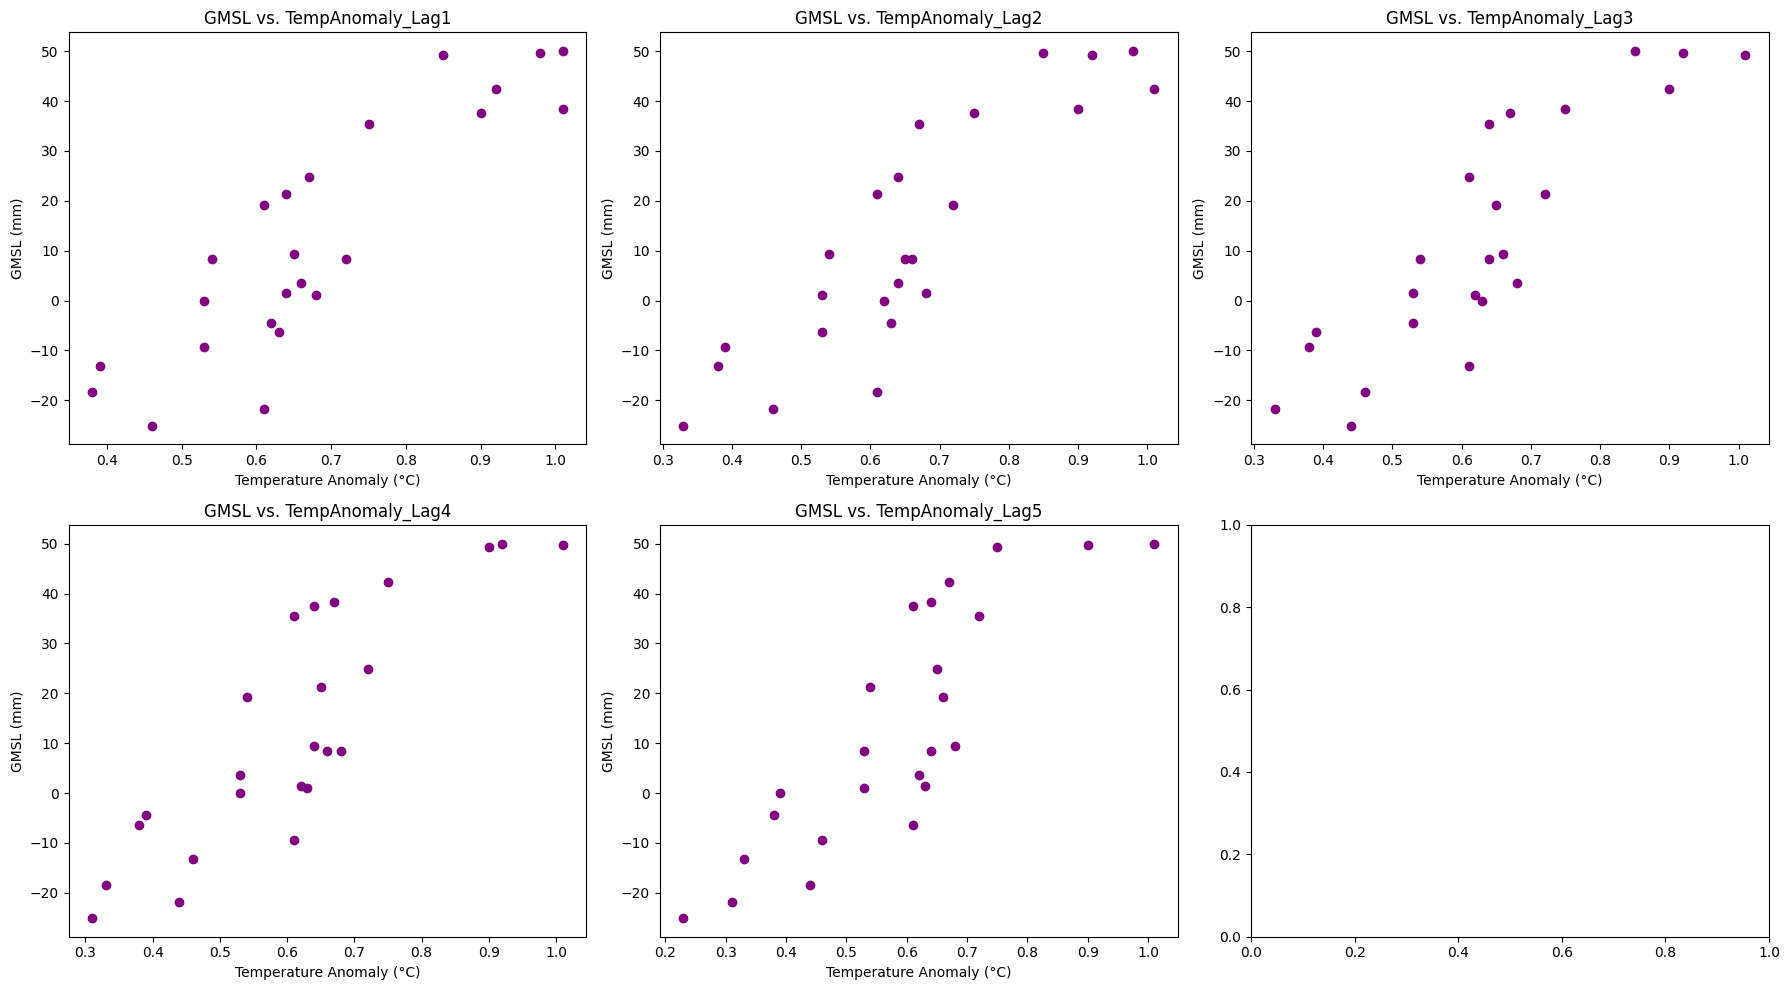

In [50]:
# Create scatter plots for each lag
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()
for i, lag in enumerate(range(1, maxlag + 1)):
    axs[i].scatter(merged_df_lagged[f'TempAnomaly_Lag{lag}'], merged_df_lagged['GMSL_noGIA'], color='purple')
    axs[i].set_title(f'GMSL vs. TempAnomaly_Lag{lag}')
    axs[i].set_xlabel('Temperature Anomaly (°C)')
    axs[i].set_ylabel('GMSL (mm)')
plt.tight_layout()
plt.show()


# Final Verdict
While temperature changes significantly impact sea level, the relationship is not straightforward and cannot be fully explained by temperature anomalies alone. Sea level rise is a multifaceted phenomenon requiring comprehensive models that consider various contributing factors.

## Evidence of Causation
The Granger Causality Test provides statistical evidence that temperature anomalies Granger-cause sea level changes at lags of 1 and 2 years. This suggests a short-term causative effect where increases in global temperatures lead to rises in sea level shortly thereafter.
